# 🎂 Segmind Challenge : Prediction of Sales of each Store🎂

## TO DO:

> Predict store sales of a store using the given dataset.

## Data:
> Dataset Given

* The dataset consists of 4 CSV files:
* TRAIN.csv : (./dataset/TRAIN.csv)
* TEST.csv: (./dataset/TEST.csv)
* store.csv - additional information regarding the stores: (./dataset/store.csv)

## Evaluate:
* Time-series prediction problem.
* Sales has direct correlation to OPEN or not

## Features:
> From Test data

* Store: Store number
* DayOfWeek: Day (out of 7) per week
* Date: DD-MM-YYYY format
* Open: 1 for open, 0 for close
* Promo: 0 or 1 
* StateHoliday: 0, a, b, c (0 or store type)
* SchoolHoliday: 0 or 1

## 🤳Imports

In [1]:
# Essentials
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from dateutil.parser import parse
from math import ceil
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pprint import pprint

import pickle

## 💚Inputs

In [2]:
# Store data
def import_store():
    storedf = pd.read_csv('./dataset/store.csv')
    return storedf
# Sales data
def import_data(x):
    df = pd.read_csv('./dataset/'+x+'.csv')
    return df

## 💌Total preprocessing

In [3]:
# Store attributes
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_with_store = ['Store','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
num_attribs = ["CompetitionDistance",
               "CompetitionOpenSinceMonth",
               "CompetitionOpenSinceYear",
               "Promo2SinceWeek",
               "Promo2SinceYear"]
# scale_attribs = ["CompetitionDistance"]
obj_attribs = ["StoreType", "Assortment"]

In [4]:
# Store Pipelines

# cd_pipeline_median = Pipeline([
#     ("imputer", SimpleImputer(strategy='median')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mean = Pipeline([
#     ("imputer", SimpleImputer(strategy='mean')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mode = Pipeline([
#     ("imputer", SimpleImputer(strategy='most_frequent')),
#     ("stdscale", StandardScaler())
# ])

full_pipeline_median = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_attribs),
    #("stdscale", StandardScaler(), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mean = ColumnTransformer([
    ("num", SimpleImputer(strategy='mean'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mode = ColumnTransformer([
    ("num", SimpleImputer(strategy='most_frequent'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

In [5]:
# Sore Preprocessing

def divide_promointerval():
    '''
    1. Fillna with '0' in PROMOINTERVAL
    2. Dividing PromoInterval into months and applying custom one hot encoding
    4. Drop PROMOINTERVAL
    ----------
    PARAMETERS
    ----------
    NA
    -------
    RETURNS
    -------    
    test: DF after divinding the Promointerval into months
    '''
    store['PromoInterval'].fillna(value='0', inplace=True)
    test = pd.DataFrame(data=store.Store, columns=months_with_store)
    for month in months:
        test[month] = np.where(store["PromoInterval"].str.contains(month), 1, 0)
    if 'PromoInterval' in store.columns:    
        store.drop('PromoInterval', inplace=True, axis=1)    
    return test

def drop_store_columns():
    '''
    Dropping columns after preprocessing.
    '''
    for attri in num_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)
    for attri in obj_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)         

In [6]:
# Store transformation
store = import_store()
store_tranformed = full_pipeline_median.fit_transform(store)
drop_store_columns()
store_prepared = pd.DataFrame(data=store_tranformed, columns=(num_attribs+obj_attribs), index=store.index)
store = store.join(store_prepared)
month_df = divide_promointerval()
store_df = pd.merge(left=store, right=month_df, on='Store')

In [7]:
# Data Preprocessing
def week_of_month(tgtdate):
    date = parse(tgtdate)
    first_day = date.replace(day=1)

    day_of_month = date.day

    if(first_day.weekday() == 6):
        adjusted_dom = (1 + first_day.weekday()) / 7
    else:
        adjusted_dom = day_of_month + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def change_tf(true_false):
    if true_false == True:
        return 1
    else:
        return 0

def date_preproccesing():
    train_df['year'] = pd.DatetimeIndex(train_df['Date']).year
    train_df['month'] = pd.DatetimeIndex(train_df['Date']).month
    train_df['quarter'] = pd.DatetimeIndex(train_df['Date']).quarter
    train_df['dayofyear'] = pd.DatetimeIndex(train_df['Date']).dayofyear
    train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
    train_df['week'] = pd.DatetimeIndex(train_df['Date']).week
    train_df['is_month_start'] = pd.DatetimeIndex(train_df['Date']).is_month_start
    train_df['is_month_end'] = pd.DatetimeIndex(train_df['Date']).is_month_end
    train_df['is_year_end'] = pd.DatetimeIndex(train_df['Date']).is_year_end
    train_df['is_year_start'] = pd.DatetimeIndex(train_df['Date']).is_year_start
    train_df["StateHoliday"] = train_df["StateHoliday"].apply(lambda x: str(x))
    train_df["WeekOfMonth"] = train_df["Date"].apply(week_of_month)
    train_df["is_month_start"] = train_df["is_month_start"].apply(lambda x: change_tf(x))
    train_df["is_month_end"] = train_df["is_month_end"].apply(lambda x: change_tf(x))
    train_df["is_year_end"] = train_df["is_year_end"].apply(lambda x: change_tf(x))
    train_df["is_year_start"] = train_df["is_year_start"].apply(lambda x: change_tf(x))

def cat_transformation(x):
    if 'train' in x:
        train_df['StateHolidayCat'] = labelencoder.fit_transform(train_df['StateHoliday'])
    else:
        train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])

def drop_data_columns():
    if 'Date' in train_df.columns:
        train_df.drop('Date', inplace=True, axis=1)
    if 'StateHoliday' in train_df.columns:
        train_df.drop('StateHoliday', axis=1, inplace=True)
    if 'Customers' in train_df.columns:
        train_df.drop('Customers', axis=1, inplace=True)

In [8]:
labelencoder = LabelEncoder()

In [9]:
# Data transformation
# labelencoder = LabelEncoder()
train_or_test = 'train' #'test' 'train'
train_df = import_data(train_or_test)
date_preproccesing()
if 'train' in train_or_test:
    labelencoder.fit(train_df['StateHoliday'])
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
#     labelencoder.fit_transform(train_df['StateHoliday'])
else:
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# cat_transformation(train_or_test)
drop_data_columns()

C:\Users\rishi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-7-1c317fd3e691>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
<ipython-input-7-1c317fd3e691>:27: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = pd.DatetimeIndex(train_df['Date']).week


In [10]:
# Final_df
# final_df = pd.merge(left=train_df, right=store_df, on='Store')
final_df = pd.merge(train_df,store_df, how='left', left_on='Store', right_on='Store')
#final_df.drop('Store', axis=1, inplace=True)

In [11]:
final_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'SchoolHoliday', 'year',
       'month', 'quarter', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start', 'WeekOfMonth',
       'StateHolidayCat', 'Promo2', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'StoreType', 'Assortment', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec'],
      dtype='object')

## 🎁Modelling

In [12]:
# Splitting the data
X = final_df.drop('Sales', axis=1)
y = final_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
# Working on MLP Regressor

MLP = MLPRegressor(verbose=True, 
                   learning_rate_init=0.06, 
                   early_stopping=True, 
                   random_state=42, 
                   validation_fraction=0.1)
MLP.fit(X_train, y_train)

Iteration 1, loss = 5544902.32058699
Validation score: 0.435569
Iteration 2, loss = 4154347.19590872
Validation score: 0.482734
Iteration 3, loss = 3933552.13317888
Validation score: 0.447516
Iteration 4, loss = 3793900.64886350
Validation score: 0.544373
Iteration 5, loss = 3685502.34232747
Validation score: 0.556578
Iteration 6, loss = 3596443.71785454
Validation score: 0.433051
Iteration 7, loss = 3586317.75696821
Validation score: 0.319296
Iteration 8, loss = 3539838.26349290
Validation score: 0.533917
Iteration 9, loss = 3519256.92816167
Validation score: 0.497266
Iteration 10, loss = 3480827.01333110
Validation score: 0.553169
Iteration 11, loss = 3470886.96758402
Validation score: 0.539749
Iteration 12, loss = 3466102.48313983
Validation score: 0.569967
Iteration 13, loss = 3440076.36306263
Validation score: 0.578197
Iteration 14, loss = 3430030.08655396
Validation score: 0.427294
Iteration 15, loss = 3444218.77275838
Validation score: 0.565220
Iteration 16, loss = 3415387.97170

MLPRegressor(early_stopping=True, learning_rate_init=0.06, random_state=42,
             verbose=True)

In [14]:
mean_absolute_error(y_test, MLP.predict(X_test))

1727.2048615049168

In [15]:
MLP.score(X_test, y_test)

0.5851425245150705

In [20]:
# Try 2
MLP = MLPRegressor(verbose=True,
                   shuffle=True,
                   early_stopping=True, 
                   random_state=42, 
                   validation_fraction=0.1)
MLP.fit(X_train, y_train)

Iteration 1, loss = 7782669.93946465
Validation score: 0.028111


C:\Users\rishi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(early_stopping=True, random_state=42, verbose=True)

<AxesSubplot:>

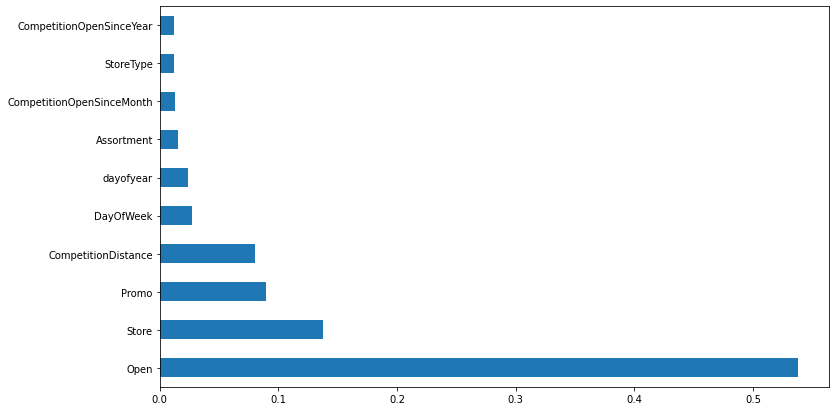

In [43]:
(pd.Series(gbrt.feature_importances_, index=X.columns)
 .nlargest(10)
   .plot(kind='barh', figsize=(12,7))) 

In [18]:
x = np.arange(10,20, dtype = float)/1000

In [19]:
x

array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019])

In [ ]:
#pickle.dump(gbrt, open("GradientBoostingRegressor.pkl","wb"))

In [47]:
results = gbrt.predict(final_df)

In [48]:
df_results = pd.DataFrame(results, index = None)
#Remove all negative
df_results[df_results < 0] = 0
df_results["Index"]=range(0, len(df_results))
df_results.columns=["Sales","Index"]

columns_titles = ["Index","Sales"]
df_results=df_results.reindex(columns=columns_titles)
#Apply Up on the Sales column
df_results['Sales'] = df_results['Sales'].apply(np.ceil)
print(df_results.info())
print(df_results.head())
df_results.to_csv("outputm3.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305163 entries, 0 to 305162
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Index   305163 non-null  int32  
 1   Sales   305163 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None
   Index   Sales
0      0   360.0
1      1  4056.0
2      2  6616.0
3      3  4410.0
4      4  7623.0
